# Polynomial regression approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr
import geopandas as gpd
import subprocess
import re
import os
import math
import rasterio
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

### Define input file info

In [2]:
img_file = "data/ang20220705t192222_rfl_v2aa2_img"
rgb_file = "data/ang20220705t192222_rfl_v2aa2_img.tif"
hdr_file = f"{img_file}.hdr"
output_file = "data/spectral_analysis.tif"

In [3]:
# Load the hyperspectral image
with rasterio.open(img_file) as src:
    hyperspectral_data = src.read()  # Retrieve reflectance data
    metadata = src.meta
    metadata = src.tags()  # Retrieve metadata
    transform = src.transform
    crs = src.crs

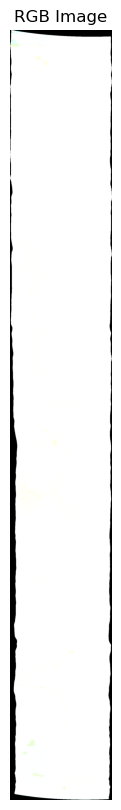

In [4]:
# print rgb
with rasterio.open(rgb_file) as src:
    # Read the RGB bands (assuming bands 1, 2, and 3 correspond to R, G, B)
    rgb_image = src.read([1, 2, 3])  # Reads R, G, B channels
    
    # clipping for normalization
    rgb_image = np.clip(rgb_image, 0, 0.1) / 0.1

    # Transpose the array to (rows, cols, bands) for plotting
    rgb_image = rgb_image.transpose((1, 2, 0))


# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("RGB Image")
plt.axis("off")  # Hide axes for a cleaner look
plt.show()

In [5]:
# Replace -9999 with NaN
hyperspectral_data[hyperspectral_data == -9999] = np.nan

In [6]:
# Plot a single Band
plot_single_band = False

if(plot_single_band):
    band_idx = 20
    plt.figure(figsize=(10, 10))
    plt.imshow(hyperspectral_data[band_idx], vmin=0, vmax=0.1, cmap='twilight_shifted')
    plt.colorbar(label="Reflectance")  # Optional: Add a color bar with a label
    plt.title("Band 1")
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

In [7]:
# Set the parameters
plot_all_bands = False
if plot_all_bands:
    # Determine number of bands
    num_bands = hyperspectral_data.shape[0]  # `bands` is the first dimension in (bands, rows, cols)
    rows, cols = math.ceil(num_bands / 10), 10  # Grid for 10 columns and calculated rows

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(23, 420))
    axes = axes.flatten()  # Flatten for easier access

    # Loop through each band
    for band_index in range(num_bands):
        # Retrieve band data for the current band
        band_data = hyperspectral_data[band_index]  # `band_index` is 0-based here

        # Extract the wavelength from metadata (adjust based on metadata structure)
        # Here assuming 'Band_X' convention where X is 1-based
        band_metadata_key = f'Band_{band_index + 1}'
        band_wavelength = metadata.get(band_metadata_key, 'Unknown Wavelength')
        band_wavelength = band_wavelength.replace("Nanometers", "nm")

        # Plot the current band
        ax = axes[band_index]  # Get the corresponding axis
        im = ax.imshow(band_data, vmin=0, vmax=0.1, cmap='twilight_shifted')
        ax.set_title(f'B{band_index + 1} {band_wavelength}')  # Set title with 1-based band index
        ax.axis('off')  # Hide axes for clean look

    # Hide any remaining empty subplots if the grid is larger than `num_bands`
    for i in range(num_bands, len(axes)):
        axes[i].axis('off')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [8]:
# Reshape to (pixels, bands)
bands, rows, cols = hyperspectral_data.shape
data_reshaped = hyperspectral_data.reshape(bands, rows * cols).T

# Impute NaN values
imputer = SimpleImputer(strategy='mean')
data_filled = imputer.fit_transform(data_reshaped)

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_filled)

# Apply PCA
num_components = 30
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(data_standardized)

# Reshape back to (rows, cols, components)
pca_image = pca_result.T.reshape(num_components, rows, cols)

# Print explained variance for each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")

Explained variance by each component: [5.12300730e-01 2.13813365e-01 1.17473923e-01 1.05880052e-01
 1.87073331e-02 9.43769235e-03 5.29648596e-03 4.18042252e-03
 2.28441996e-03 2.05216347e-03 1.11099053e-03 9.70379508e-04
 6.81098958e-04 6.14326331e-04 4.94472915e-04 4.43236378e-04
 4.11794288e-04 3.07452952e-04 2.97235179e-04 2.43021830e-04
 2.36970445e-04 2.09267950e-04 1.69452149e-04 1.53413377e-04
 1.33216847e-04 1.27839419e-04 1.09521410e-04 1.06669162e-04
 1.00866804e-04 9.49291571e-05]
Total explained variance: 0.9984427690505981


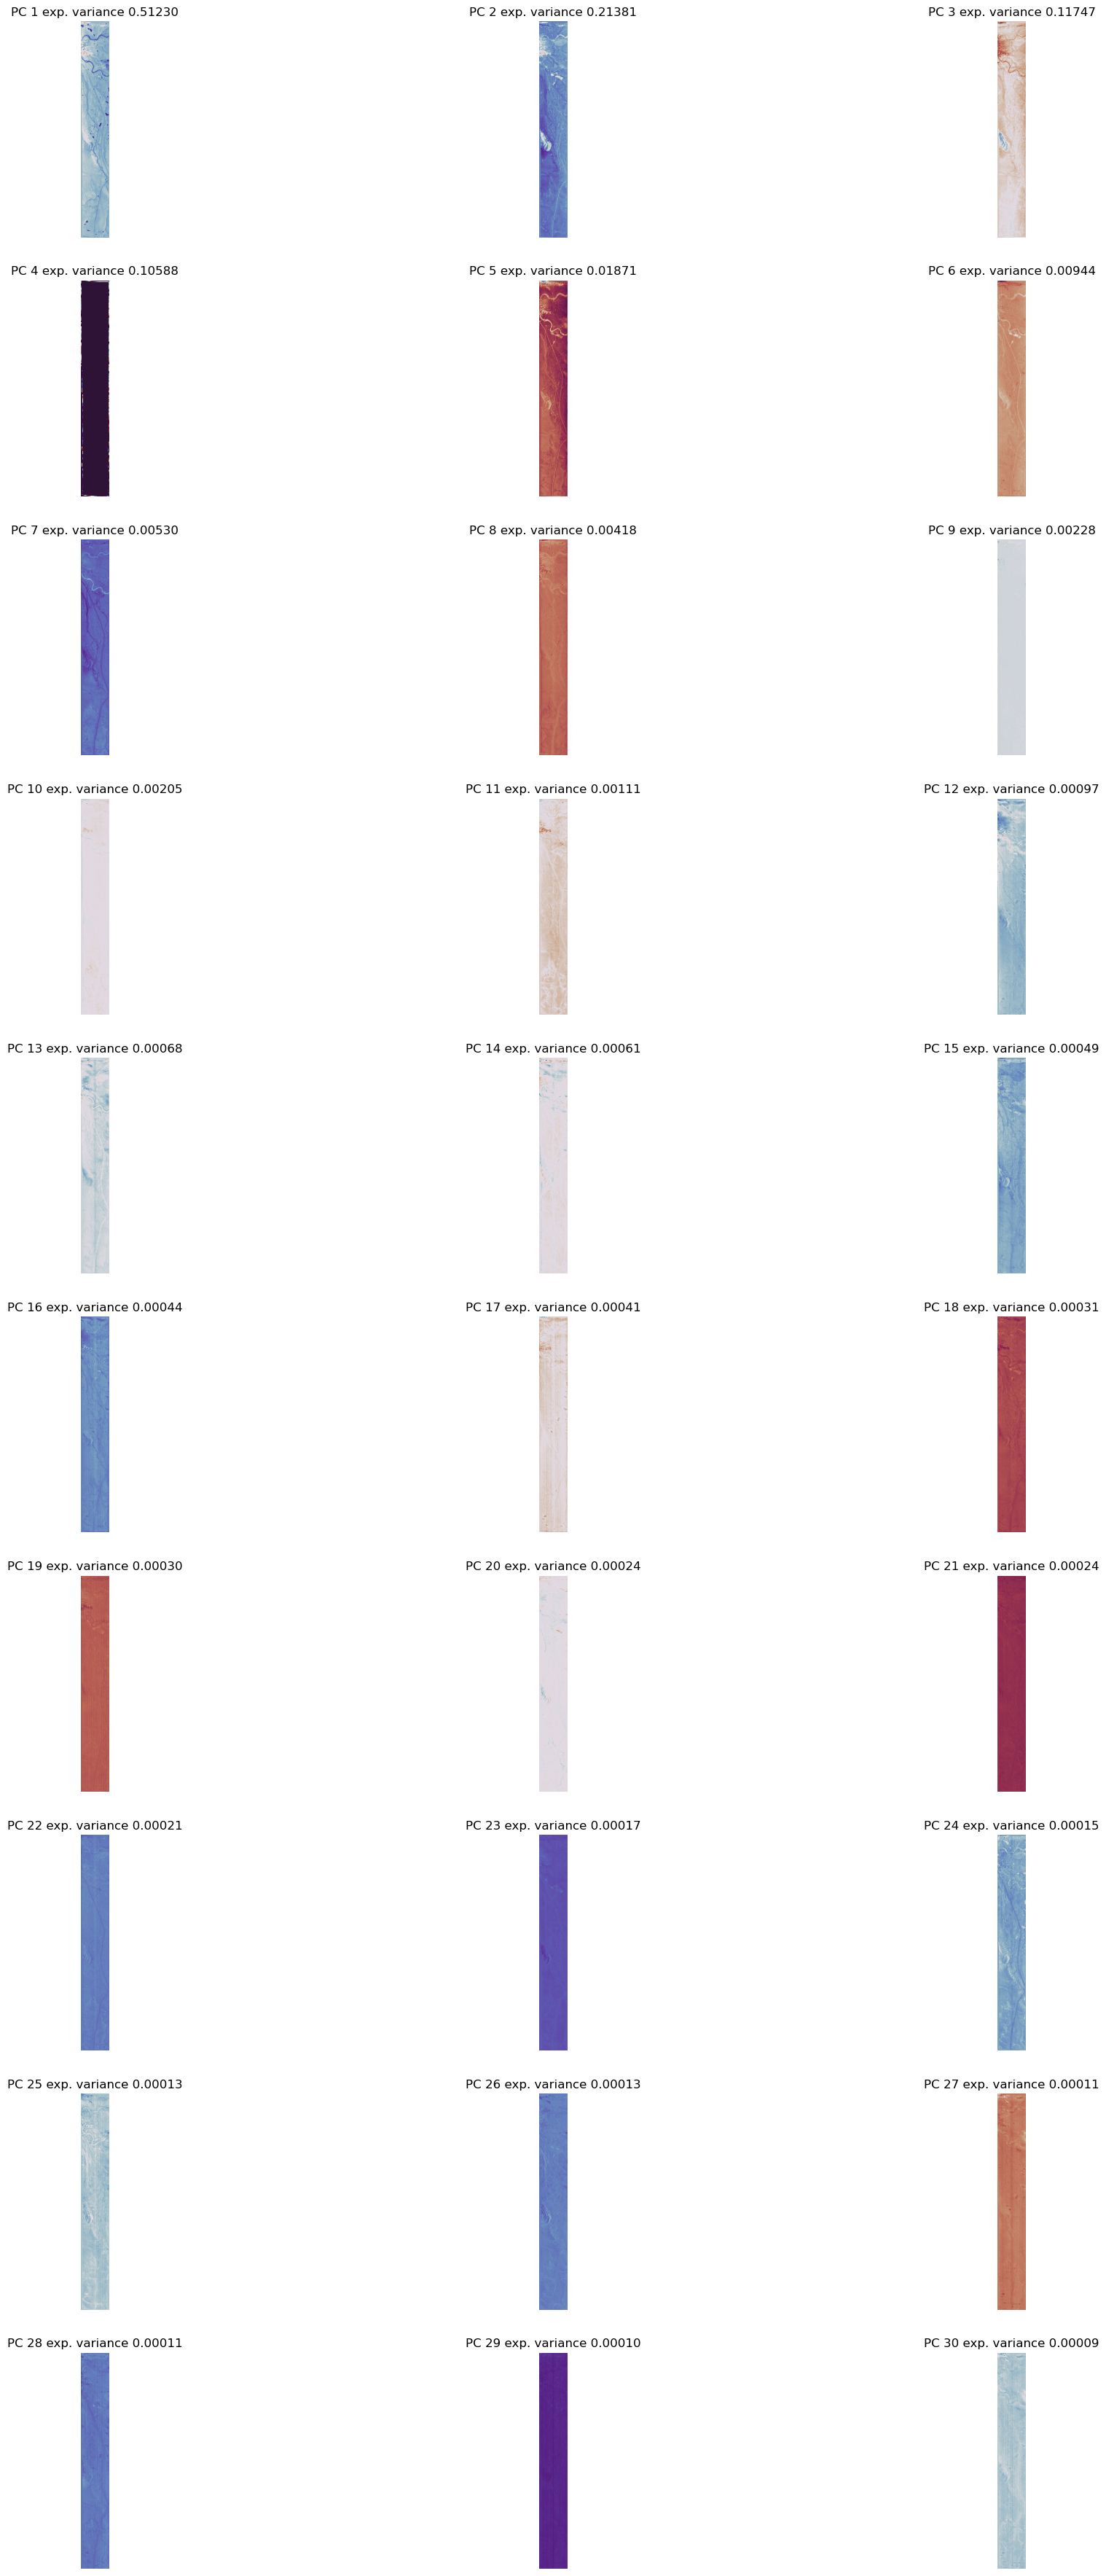

In [9]:
plot_all_pcs = True

if(plot_all_pcs):
    # Assuming 'pca_image' is of shape (num_components, rows, cols)
    num_components, rows, cols = pca_image.shape

    # Display each PCA component as an individual grayscale image
    fig, axes = plt.subplots(nrows=(num_components // 3) + 1, ncols=3, figsize=(23, 50))
    axes = axes.flatten()

    for i in range(num_components):
        ax = axes[i]
        # Normalize the component for display
        component_normalized = (pca_image[i] - np.min(pca_image[i])) / (np.max(pca_image[i]) - np.min(pca_image[i]))
        ax.imshow(component_normalized, cmap='twilight_shifted')
        # Using the % operator to round to 2 decimal places
        expl_variance = "%.5f" % explained_variance[i]
        ax.set_title(f"PC {i + 1} exp. variance {expl_variance}")
        ax.axis("off")

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    #plt.tight_layout()
    plt.show()

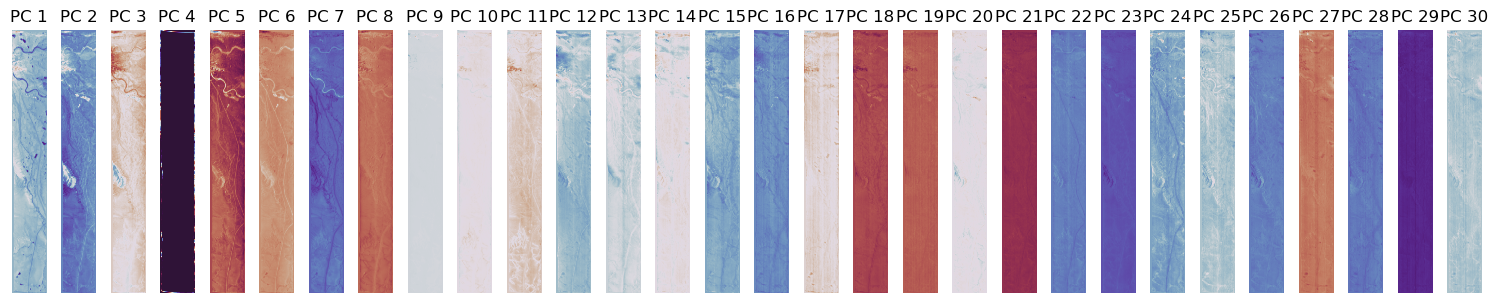

In [10]:
selected_pcs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
pca_image_selection = pca_image[selected_pcs, :, :]

# To visualize the selected PCs
fig, axes = plt.subplots(1, len(selected_pcs), figsize=(15, 15))
for i, pc_index in enumerate(selected_pcs):
    ax = axes[i]
    ax.imshow(pca_image[pc_index, :, :], cmap='twilight_shifted')
    ax.set_title(f'PC {pc_index + 1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Perform polynomial regression

In [11]:
perform_reg_parallel = True

if(perform_reg_parallel):
    import numpy as np
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from joblib import Parallel, delayed

    # Example shape parameters
    num_pcs, rows, cols = pca_image_selection.shape

    # Initialize an array to store polynomial coefficients for each pixel
    degree = 5  # Example degree for polynomial regression
    poly_features = PolynomialFeatures(degree)
    coefficients = np.zeros((rows, cols, poly_features.fit_transform(np.arange(1, num_pcs + 1)[:, None]).shape[1]))

    def fit_polynomial(i, j):
        """Function to fit polynomial regression for a given pixel."""
        # Extract the pixel values across selected PCs
        y = pca_image_selection[:, i, j]
        
        # Create a feature matrix for polynomial fitting (independent variable is the PC index)
        X = np.arange(1, num_pcs + 1).reshape(-1, 1)
        X_poly = poly_features.fit_transform(X)
        
        # Fit polynomial regression
        model = LinearRegression().fit(X_poly, y)
        
        return model.coef_  # Return the polynomial coefficients

    # Use joblib to parallelize the fitting process
    results = Parallel(n_jobs=-1)(delayed(fit_polynomial)(i, j) for i in range(rows) for j in range(cols))

    # Store the results back into the coefficients array
    for idx, (i, j) in enumerate(((i, j) for i in range(rows) for j in range(cols))):
        coefficients[i, j, :] = results[idx]

    # Flatten the coefficients array for clustering
    flat_coefficients = coefficients.reshape(rows * cols, -1)

In [12]:

unique_coefficients = np.unique(flat_coefficients, axis=0)
len_unique_coefficients = len(unique_coefficients)

print(f"From {len(flat_coefficients)} equations, {len_unique_coefficients} unique ones could be identified. Ratio: {round(len_unique_coefficients/len(flat_coefficients)*100,2)}% are unique")

From 3227007 equations, 3038682 unique ones could be identified. Ratio: 94.16% are unique


### Cluster coefficients into groups

/tmp/ipykernel_453/621573575.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_colors = plt.cm.get_cmap('Spectral_r', n_clusters)


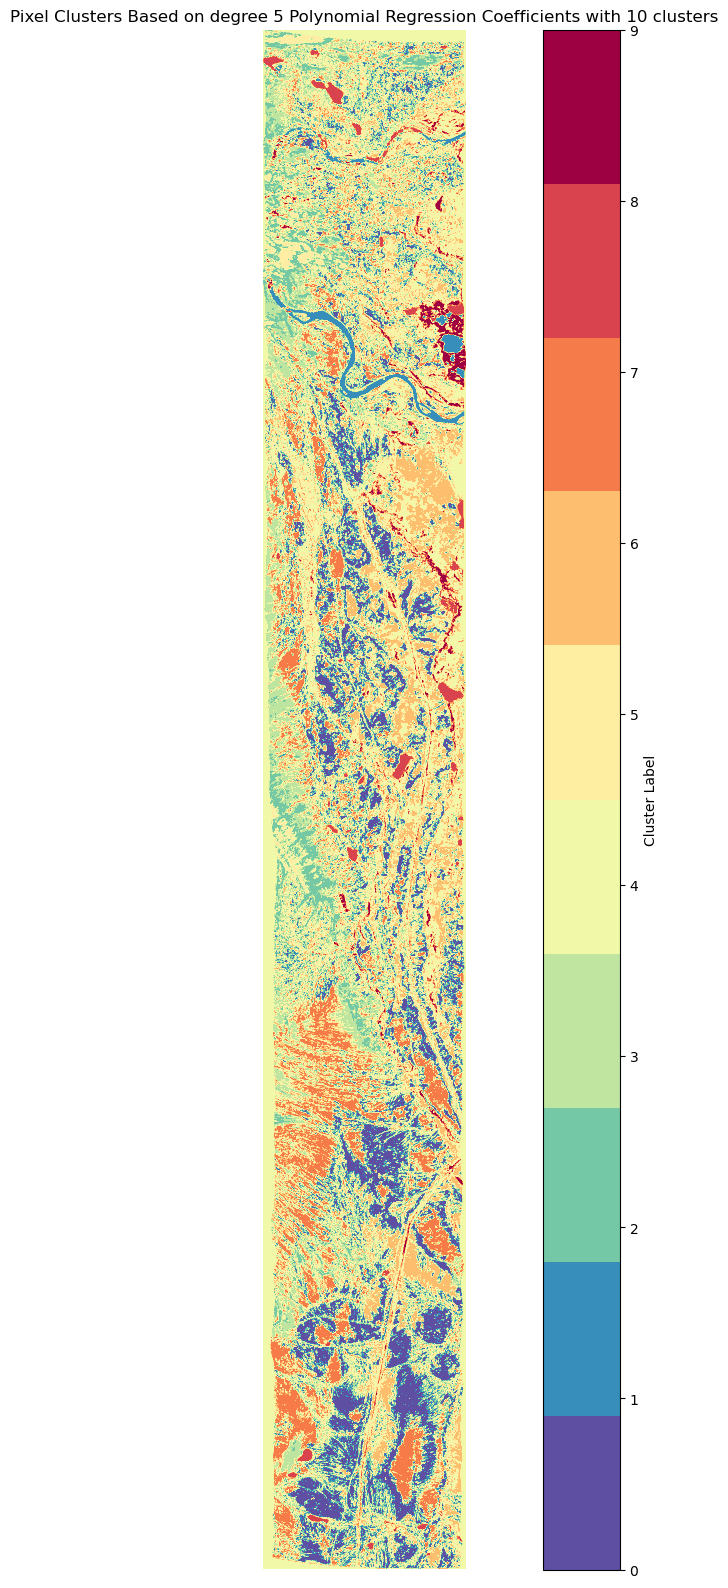

In [13]:
# Apply clustering (e.g., KMeans) to cluster pixels based on polynomial coefficients
n_clusters = 10  # Example number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(flat_coefficients)

# Reshape clustering results back to the original image dimensions
clusters = kmeans.labels_.reshape(rows, cols)

# Plot clusters (each cluster will be visualized with a unique color)

# Custom colormap with exactly 10 colors
custom_colors = plt.cm.get_cmap('Spectral_r', n_clusters)
custom_cmap = ListedColormap(custom_colors(np.linspace(0, 1, n_clusters)))

plt.figure(figsize=(20, 20))
plt.imshow(clusters, cmap=custom_cmap)
plt.colorbar(label="Cluster Label")
plt.title(f"Pixel Clusters Based on degree {degree} Polynomial Regression Coefficients with {n_clusters} clusters")
plt.axis("off")
plt.show()

In [15]:
#list(colormaps)

### Cluster in blocks (if wanted)

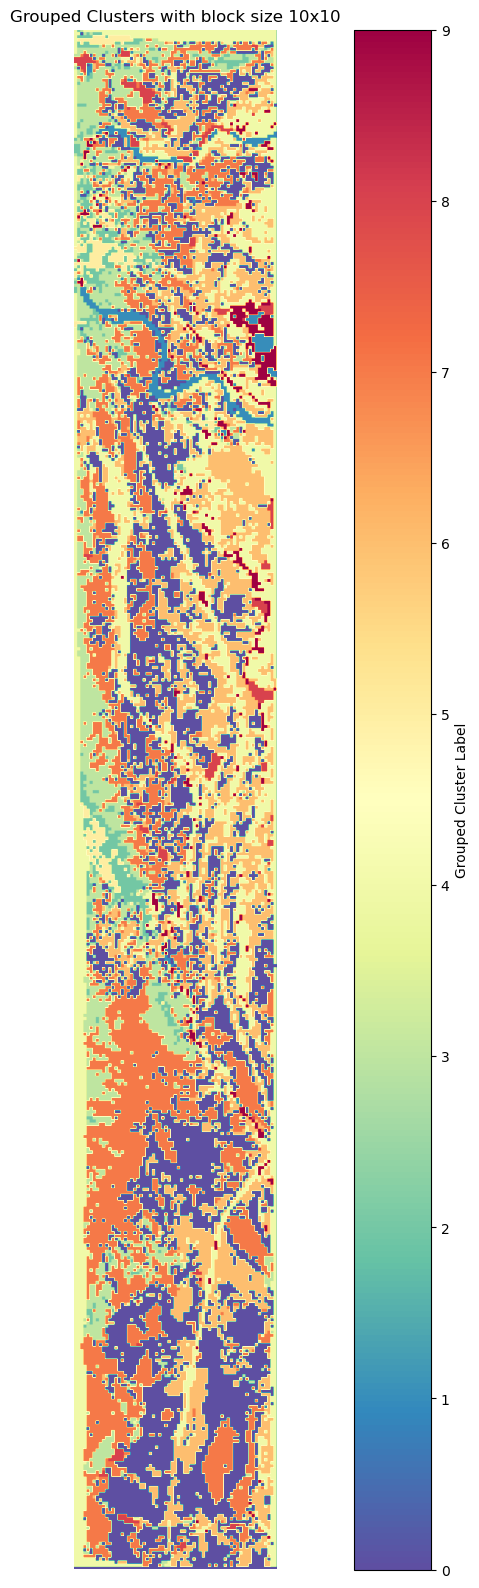

In [16]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt

# Example cluster data: Replace `clusters` with your clustering result array
# clusters = kmeans.labels_.reshape(rows, cols)

# Desired block size for further clustering
block_size = 10

# Get the dimensions of the clusters array
rows, cols = clusters.shape

# Calculate the number of complete blocks in both dimensions
complete_rows = rows - (rows % block_size)  # largest multiple of block_size <= rows
complete_cols = cols - (cols % block_size)  # largest multiple of block_size <= cols

# Create an output array to store the new cluster labels at original dimensions
grouped_clusters = np.zeros_like(clusters, dtype=int)

# Loop through each complete 5x5 block
for i in range(0, complete_rows, block_size):
    for j in range(0, complete_cols, block_size):
        # Get the 5x5 block
        block = clusters[i:i + block_size, j:j + block_size]

        # Calculate the most frequent cluster label in this block
        mode_result = mode(block, axis=None)

        # Extract the mode value correctly, handling scalar and array cases
        #most_common_cluster = mode_result.mode[0] if mode_result.mode.size > 0 else mode_result.mode
        most_common_cluster = mode_result.mode

        # Assign the most common cluster value to the entire block in grouped_clusters
        grouped_clusters[i:i + block_size, j:j + block_size] = most_common_cluster

# Plot the grouped clusters
plt.figure(figsize=(20, 20))
plt.imshow(grouped_clusters, cmap='Spectral_r')  # Adjust the colormap as needed
plt.colorbar(label="Grouped Cluster Label")
plt.title(f"Grouped Clusters with block size {block_size}x{block_size}")
plt.axis("off")
plt.show()

In [17]:
# Save the cluster map as a GeoTIFF
with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=clusters.shape[0],
    width=clusters.shape[1],
    count=1,  # single band for the cluster map
    dtype=clusters.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(clusters, 1)  # Write the data to the first band

print(f"Cluster map saved as {output_file}")

Cluster map saved as data/spectral_analysis.tif
